In [6]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as prp
from pandas.api.types import is_numeric_dtype

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import sys
import pprint
import os


In [7]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_555842/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [8]:
dataset = pd.read_csv('/mnt/4CB2D623B2D610F6/Projects/Extra/MLProject/test-apps/StreamLit-app/music-recommendation-app/Datasets/useful_feature.csv')

In [9]:
complete_feature_set = pd.read_csv('/mnt/4CB2D623B2D610F6/Projects/Extra/MLProject/test-apps/StreamLit-app/music-recommendation-app/Datasets/complete_feature.csv')

# Connect to Spotify API

In [10]:
client_id = '04787040c97949849646c82ef8b93796'
client_secret= '3400c76e285e4f9d92bcba39de3db775'

os.environ["SPOTIPY_CLIENT_ID"] = "04787040c97949849646c82ef8b93796"
os.environ["SPOTIPY_CLIENT_SECRET"] = "3400c76e285e4f9d92bcba39de3db775"


In [11]:
scope = 'user-library-read'

auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

# Get audio features from spotify     

1. track_id	
2. artists	
3. track_genre	
4. mode	
5. key	
6. popularity	
7. danceability	
8. energy	
9. speechiness	
10. acousticness	
11. liveness	
12. valence	
13. tempo


# Features missing from audio_features

* popularity
* track_genre
* artist

In [12]:
heyJude = 'spotify:track:1eT2CjXwFXNx6oY5ydvzKU'
track_feature = sp.audio_features(heyJude)

track_feature[0]['danceability']

0.462

# Creating features for each track

In [13]:
def extract_track_features(track_uri):
  track_features = sp.audio_features(track_uri)[0]
  remove_list = ['loudness', 'type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']
  
  track_features = {k: v for k, v in track_features.items() if k not in remove_list}

  return track_features

In [14]:
extract_track_features(heyJude)

{'danceability': 0.462,
 'energy': 0.632,
 'key': 5,
 'mode': 1,
 'speechiness': 0.0248,
 'acousticness': 0.091,
 'instrumentalness': 0,
 'liveness': 0.397,
 'valence': 0.585,
 'tempo': 74.268,
 'id': '1eT2CjXwFXNx6oY5ydvzKU'}

In [15]:
uri = sp.track(heyJude)['artists'][0]['uri']
sp.artist(uri)['popularity']

84

In [16]:
def extract_popularity_genre(track_uri):
  artist_uri = sp.track(track_uri)['artists'][0]['uri']
  artist_detail = sp.artist(artist_uri)

  artist_genre = artist_detail['genres']
  artist_popularity = artist_detail['popularity']

  for idx, x in enumerate(artist_genre):
    artist_genre[idx] = x.lower().replace(" ", "").replace("-", "").replace(".", "")

  dic = {'track_genres' : [artist_genre],
         'popularity' : artist_popularity}
  
  return dic


In [17]:
artist_list = sp.track('1iJBSr7s7jYXzM8EGcbK5b')['artists']
artist_names = []
for idx, x in enumerate(artist_list):
    artist_names.append(artist_list[idx]['name'])
artist_names

['Ingrid Michaelson', 'ZAYN']

In [18]:
track_name = sp.track('1iJBSr7s7jYXzM8EGcbK5b')['name']
track_name

'To Begin Again'

In [19]:
track_image = sp.track('0KSOLEBixnBYIKNHF1VbzF')['album']['images'][0]['url']
track_image

'https://i.scdn.co/image/ab67616d0000b27371ef95ca0f8a1270a3cebc05'

In [20]:
extract_popularity_genre(heyJude)

{'track_genres': [['beatlesque',
   'britishinvasion',
   'classicrock',
   'merseybeat',
   'psychedelicrock',
   'rock']],
 'popularity': 84}

In [21]:
def create_feature_for_track(track_uri):
  track_features = extract_track_features(track_uri)
  artist_features = extract_popularity_genre(track_uri)
  
  res_dic = artist_features | track_features
  return pd.DataFrame(res_dic)


In [22]:
res_song_df = create_feature_for_track(heyJude)


In [23]:
res_song_df

,track_genres,popularity,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id
0,"[beatlesque, britishinvasion, classicrock, mer...",84,0.462,0.632,5,1,0.0248,0.091,0,0.397,0.585,74.268,1eT2CjXwFXNx6oY5ydvzKU


## Normalize

In [24]:
def ohe_prep(df, column, new_name): 
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [25]:
key_ohe = ohe_prep(res_song_df, 'key','key') * 0.5
mode_ohe = ohe_prep(res_song_df, 'mode','mode') * 0.5

In [26]:
float_cols = res_song_df.dtypes[res_song_df.dtypes == 'float64'].index.values


In [27]:


pop = res_song_df[['popularity']].reset_index(drop = True)
scaler = MinMaxScaler()
pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) * 0.2 

floats = res_song_df[float_cols].reset_index(drop = True)
scaler = MinMaxScaler()
floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2



In [28]:
final_song_feature = pd.concat([key_ohe, mode_ohe, pop_scaled, floats_scaled], axis = 1)
final_song_feature['id'] = res_song_df['id'].values

In [29]:
final_song_feature

,key|5,mode|1,popularity,danceability,energy,speechiness,acousticness,liveness,valence,tempo,id
0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1eT2CjXwFXNx6oY5ydvzKU


# Generate the playlist dataframe

In [30]:
test_playlist_id = '37i9dQZF1EQnqst5TRi17F'

In [31]:
def create_playlist_df_that_in_dataset(playlist_id, dataset):
  playlist = pd.DataFrame()

  for ix, i in enumerate(sp.playlist_tracks(playlist_id)['items']):
    playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
    playlist.loc[ix, 'name'] = i['track']['name']
    playlist.loc[ix, 'track_id'] = i['track']['id'] # ['uri'].split(':')[2]
    # playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']

  # playlist['date_added'] = pd.to_datetime(playlist['date_added'])

  playlist = playlist[playlist['track_id'].isin(dataset['track_id'].values)]

  return playlist

In [32]:
playlist_in_df  = create_playlist_df_that_in_dataset(test_playlist_id, dataset)
playlist_in_df


,artist,name,track_id
3,The Notorious B.I.G.,Big Poppa - 2005 Remaster,2g8HN35AnVGIk7B8yMucww
6,Dr. Dre,What's The Difference,1SWVDBtw6h3tm9OehOkDhv
7,Wu-Tang Clan,"Protect Ya Neck (feat. RZA, Method Man, Inspec...",1Sgj10byiGzPpI2IrXSFEn
8,2Pac,All Eyez On Me (ft. Big Syke),4VQNCzfZ3MdHEwwErNXpBo
9,Nas,N.Y. State of Mind,0trHOzAhNpGCsGBEu7dOJo
10,Ice Cube,You Know How We Do It,2Ih217RCGAmyQR68Nn7Cqo
11,The Notorious B.I.G.,Hypnotize - 2014 Remaster,7KwZNVEaqikRSBSpyhXK2j
13,50 Cent,In Da Club,7iL6o9tox1zgHpKUfh9vuC
14,Eminem,Till I Collapse,4xkOaSrkexMciUUogZKVTS
15,Wu-Tang Clan,"Triumph (feat. Ol' Dirty Bastard, Inspectah De...",3glqlA5qY3bbo8UaUDGPnw


# Generate Track Dataframe

In [33]:
def create_track_df_that_in_dataset(track_id, dataset):
  track = pd.DataFrame()

  track['artist'] = sp.track(track_id)['artists'][0]['name']  
  track['name'] = sp.track(track_id)['name']
  track['track_id'] = track_id

  return track

# Generate Playlist Features

In [34]:
complete_feature_set[complete_feature_set['track_id'].isin(playlist_in_df['track_id'].values)]

,genre|acoustic,genre|afrobeat,genre|alternative,genre|altrock,genre|ambient,genre|anime,genre|blackmetal,genre|bluegrass,genre|blues,genre|brazil,...,key|5,key|6,key|7,key|8,key|9,key|10,key|11,mode|0,mode|1,track_id
33520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,503OTo2dSqe7qk76rgsbep
33616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0Z2J91b2iTGLVTZC4fKgxf
33637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,2Ih217RCGAmyQR68Nn7Cqo
33638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,4VQNCzfZ3MdHEwwErNXpBo
33750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,1SWVDBtw6h3tm9OehOkDhv
33786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,1ofhfV90EnYhEr7Un2fWiv
33923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0XRbYXQUymj9SJkrr8YK5B
42537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,7KwZNVEaqikRSBSpyhXK2j
42540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,2g8HN35AnVGIk7B8yMucww
42564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0trHOzAhNpGCsGBEu7dOJo


In [35]:
def generate_playlist_feature(complete_feature_set, playlist_in_df):
  complete_feature_set_playlist = complete_feature_set[complete_feature_set['track_id'].isin(playlist_in_df['track_id'].values)]
  complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['track_id'].isin(playlist_in_df['track_id'].values)]
  complete_feature_set_playlist_final = complete_feature_set_playlist.drop(columns = "track_id")

  return complete_feature_set_playlist_final.sum(axis = 0), complete_feature_set_nonplaylist

In [36]:
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist_in_df)


# Generate Recommendation

In [37]:
def generate_recommendation(dataset, playlist_vector, nonplaylist_features):
  non_playlist_df = dataset[dataset['track_id'].isin(nonplaylist_features['track_id'].values)]

  non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('track_id', axis = 1).values, playlist_vector.values.reshape(1, -1))[:,0]

  return non_playlist_df.sort_values('sim',ascending = False)

In [38]:
recommend = generate_recommendation(dataset,complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)

/tmp/ipykernel_555842/3312592350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('track_id', axis = 1).values, playlist_vector.values.reshape(1, -1))[:,0]


In [39]:
recommend.head()


,track_id,artists,track_genre,mode,key,popularity,danceability,energy,speechiness,acousticness,liveness,valence,tempo,sim
42870,6phmKeRhJUsiSBJgMkgjg8,['nwa'],['hardcore'],1,7,60,0.709,0.874,0.1930,0.01140,0.2130,0.832,88.546,0.800666
42868,6dRj771QZr0KOQVwaB6ykM,"['peterock', 'ini']",['hardcore'],1,7,62,0.801,0.757,0.3160,0.47800,0.1630,0.607,88.025,0.799889
43253,3OMqeZU9lQGimMwMjPvBsp,['nwa'],['hardcore'],1,7,57,0.830,0.795,0.1810,0.03480,0.0864,0.402,105.525,0.796635
42670,06UPCXzhIsXnceSXmKLMEY,['nas'],['hardcore'],1,7,55,0.573,0.831,0.4330,0.04010,0.0909,0.766,76.352,0.796604
43119,5jZ1Z2GFTf2gwmFc3qiUxs,['theused'],['hardcore'],1,7,67,0.541,0.904,0.0435,0.00143,0.1930,0.541,98.122,0.795439


In [40]:
sp.track('0KSOLEBixnBYIKNHF1VbzF')['album']['images'][0]['url']

'https://i.scdn.co/image/ab67616d0000b27371ef95ca0f8a1270a3cebc05'

# Storing top X in new DF

In [41]:
def get_top_rec(recommend, top):
  res_df = recommend.head(top).copy()
  
  print(res_df['track_id'])
  res_df['track_name'] = res_df['track_id'].apply(lambda x : sp.track(x)['name'])
  res_df['artist_name'] = res_df['track_id'].apply(lambda x : sp.track(x)['artists'][0]['name'])
  res_df['image_url'] = res_df['track_id'].apply(lambda x : sp.track(x)['album']['images'][0]['url'])

  return res_df

In [42]:
res_recommended = get_top_rec(recommend, 5)

42870    6phmKeRhJUsiSBJgMkgjg8
42868    6dRj771QZr0KOQVwaB6ykM
43253    3OMqeZU9lQGimMwMjPvBsp
42670    06UPCXzhIsXnceSXmKLMEY
43119    5jZ1Z2GFTf2gwmFc3qiUxs
Name: track_id, dtype: object


# Visualize Image

In [43]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    temp = df['image_url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    num_columns = 5
    
    for i, url in enumerate(temp):
      num_rows = len(temp) / num_columns
      plt.subplot(int(num_rows), num_columns, i + 1)

      image = io.imread(url)
      plt.imshow(image)
      plt.xticks(color = 'w', fontsize = 0.1)
      plt.yticks(color = 'w', fontsize = 0.1)
      plt.xlabel(df['track_name'].values[i], fontsize = 12)
      plt.tight_layout(h_pad=0.4, w_pad=0)
      plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [44]:
res_recommended['image_url'].values

array(['https://i.scdn.co/image/ab67616d0000b27377cf4557b2899021f216c8dd',
       'https://i.scdn.co/image/ab67616d0000b273cfdb24aacae1d7c5168df6db',
       'https://i.scdn.co/image/ab67616d0000b273ad7c319723dfb1a976524c49',
       'https://i.scdn.co/image/ab67616d0000b273d74ce62a1d666f9ebb665150',
       'https://i.scdn.co/image/ab67616d0000b273e0827a6cec3f1574249ec8c0'],
      dtype=object)

/tmp/ipykernel_555842/932424390.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(int(num_rows), num_columns, i + 1)


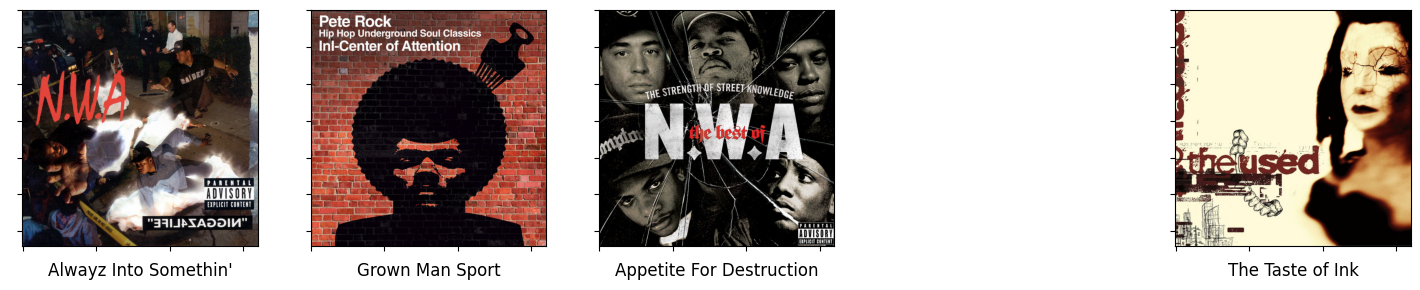

In [45]:
visualize_songs(res_recommended)

# Playlist recommender

In [46]:
playlist_id = '37i9dQZF1DX6bnzK9KPvrz'

playlist_in_df  = create_playlist_df_that_in_dataset(playlist_id, dataset)

complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist_in_df)

recommend = generate_recommendation(dataset,complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)

res_recommended = get_top_rec(recommend, 6)
res_recommended

/tmp/ipykernel_555842/3312592350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('track_id', axis = 1).values, playlist_vector.values.reshape(1, -1))[:,0]


67627    3ZGJhN4unVspOqpwGvUL2W
67623    2eAvDnpXP5W0cVtiI0PUxV
67641    0ZHILXmUaVSLEOCWxPQ1ga
67869    5fXslGZPI5Cco6PKHzlSL3
67833    7d4ZrG3Cer7jbqIl6wOI6D
67927    5mNOfozRJBZGnq4gO4rwM2
Name: track_id, dtype: object


IndexError: list index out of range

In [ ]:
res_recommended['track_id'].to_list()

['4cktbXiXOapiLBMprHFErI',
 '0WtM2NBVQNNJLh6scP13H8',
 '3oWxFNsXstcancCR1wODR4',
 '0Qxis7LXvwqhCO2qOKCmLX',
 '6JUQViD0hLXlvWXCV4uUF8',
 '1AzNN19lPYC68iacrbWL8X']

# Single track recommender

In [ ]:
track_id = '7HtPBwBoCBDy1tpstag7HL'

track_in_df  = create_track_df_that_in_dataset(track_id, dataset)

track_in_df


,artist,name,track_id


In [ ]:
sp.track('5mNOfozRJBZGnq4gO4rwM2')['album']['images'][0]['url']

'https://i.scdn.co/image/ab67616d0000b2733d456e82e1eea005bbaa87bb'

In [ ]:
img_url = 'https://i.scdn.co/image/ab67616d0000b2739180ec245c2d22d169155c79'
target_url = "https://www.geeksforgeeks.org/string-formatting-in-python/"

markdown_output = "[![Foo](%s)](%s)" %(img_url, target_url)
markdown_output

'[![Foo](https://i.scdn.co/image/ab67616d0000b2739180ec245c2d22d169155c79)](https://www.geeksforgeeks.org/string-formatting-in-python/)'

In [ ]:
s = "abc"
s = s + "efc"
s

'abcefc'